## Librerías

In [174]:
import pandas as pd; import matplotlib.pyplot as plt; import numpy as np; import seaborn as sns

## Lectura y preprocesamiento

In [175]:
df = pd.read_csv('Amazon_Products.csv').drop(columns=['Unnamed: 0'])

In [177]:
#-------------------------Estilos para los gráficos
import matplotlib as mpl
plt.style.use("fivethirtyeight") 
mpl.rcParams["font.size"]=10.5 
mpl.rcParams["legend.fontsize"]=14
mpl.rcParams["font.family"]="serif"
mpl.rcParams["font.weight"]="bold"
mpl.rcParams["legend.fancybox"]=True
mpl.rcParams["xtick.labelsize"]=10
mpl.rcParams["ytick.labelsize"]=16
mpl.rcParams["figure.titleweight"]="bold"
mpl.rcParams["axes.labelweight"]="bold"
mpl.rcParams["figure.facecolor"]="white"
mpl.rcParams["axes.facecolor"]="white"
mpl.rcParams["axes.edgecolor"]="0.2"
mpl.rcParams["axes.linewidth"]=1
mpl.rcParams["axes.titleweight"]="bold"
mpl.rcParams["axes.labelsize"]=16
mpl.rcParams["figure.titlesize"]=20
mpl.rcParams["axes.titlesize"]=25
mpl.rcParams["figure.labelsize"]=16
mpl.rcParams["figure.labelweight"]="bold"
mpl.rcParams['axes.grid']=False

In [185]:
[1,2,3].get(2)

AttributeError: 'list' object has no attribute 'get'

In [178]:
# df.info()

##Conversión de las columnas ratings, numero de ratings, discount_price y actual_price a numérico


def validar_tipo(x):
    try:
        type(float(x)==float)
        return np.float32(x)
    except ValueError:
        return np.nan
    
df['discount_price'] = df['discount_price'].str.replace('₹','')
df['actual_price'] = df['actual_price'].str.replace('₹','')
df['discount_price'] = df['discount_price'].str.replace(',','')
df['actual_price'] = df['actual_price'].str.replace(',','')


df['ratings'] = df['ratings'].apply(validar_tipo)
df['no_of_ratings'] = df['no_of_ratings'].apply(validar_tipo)
df['discount_price'] = df['discount_price'].apply(validar_tipo)
df['actual_price'] = df['actual_price'].apply(validar_tipo)

df['ratings'] = df['ratings'].fillna(df['ratings'].mean())
df['no_of_ratings'] = df['no_of_ratings'].fillna(df['no_of_ratings'].mean())
df['discount_price'] = df['discount_price'].fillna(df['discount_price'].mean())
df['actual_price'] = df['actual_price'].fillna(df['actual_price'].mean())

def optimizar_tipo_dato (serie):
    return serie.astype(np.float32)

df['ratings'] = optimizar_tipo_dato(df['ratings'])
df['no_of_ratings'] = optimizar_tipo_dato(df['no_of_ratings'])
df['discount_price'] = optimizar_tipo_dato(df['discount_price'])
df['actual_price'] = optimizar_tipo_dato(df['actual_price'])

## Análisis exploratorio de datos

In [179]:
##Distribución de los datos numéricos

##Eliminar valores atípicos

def outliers(serie):
    q1 = serie.quantile(0.25)
    q3 = serie.quantile(0.75)
    iqr = q3 -q1
    sup_lim = q3 + 1.5*iqr
    inf_lim = q1 - 1.5*iqr
    serie_clean = serie.loc[(serie>=inf_lim)&(serie<=sup_lim)]
    return serie_clean

df['actual_price'] = outliers(df['actual_price'])
df['discount_price'] = outliers(df['discount_price'])
df['ratings'] = outliers(df['ratings'])
df['no_of_ratings'] = outliers(df['no_of_ratings'])

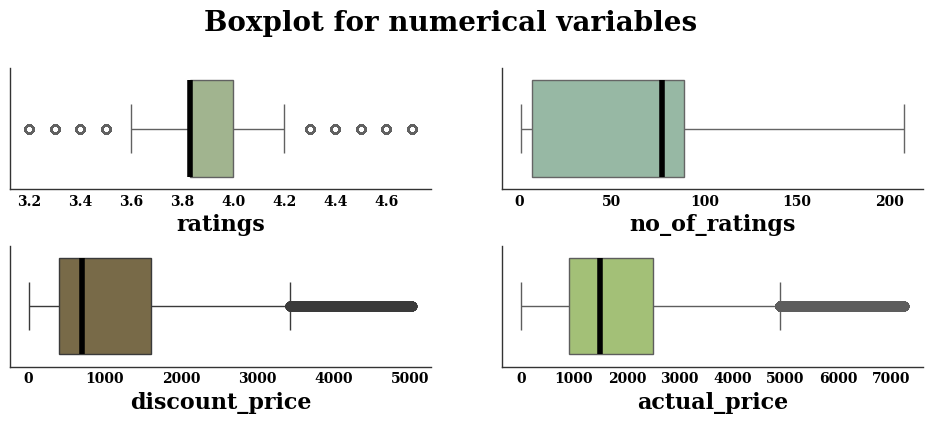

In [180]:
numerical = df.select_dtypes('number')

fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(10,4))
fig.suptitle('Boxplot for numerical variables')
fig.tight_layout(h_pad=2)
colors = ['#A1BA89','#92BDA3','#806D40','#A5CC6B']
ax = ax.flat

for i, col in enumerate(numerical):
    ax[i].spines[['top','right']].set_visible(False)
    sns.boxplot(x=numerical[col],ax=ax[i],color=colors[i],medianprops={'color':'k','lw':4})

In [181]:
### Categorías de las variables no numéricas

df[['name','main_category','sub_category']].nunique()

name             396210
main_category        20
sub_category        112
dtype: int64

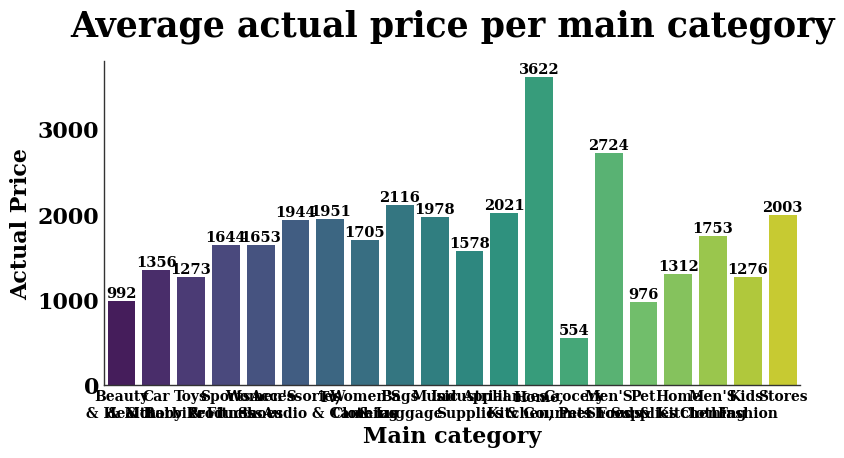

In [182]:
#### Calificación y precio promedio por categoría principal


# top_ratings = df.groupby('main_category')[['ratings','actual_price']].mean().reset_index().sort_values(by='ratings',ascending=False)
top_ratings = df.groupby('main_category')[['ratings','actual_price']].mean().reset_index().sample(20)
# top_ratings = df.groupby('main_category')[['ratings']].mean().reset_index().sort_values(by='ratings',ascending=False).head(5)

labels = [i.replace(' ','\n',1).title() for i in top_ratings['main_category']]
fig, ax = plt.subplots(figsize=(8,4))

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
sns.barplot(data=top_ratings,x='main_category',y='actual_price',hue='main_category',palette='viridis')

for x , y in enumerate(top_ratings['actual_price']):
    ax.text(x,y,f'{y:.0f}',va='bottom',ha='center')

ax.set_xlabel('Main category')
ax.set_ylabel('Actual Price')
ax.set_title('Average actual price per main category',y=1.05)
ax.spines[['top','right']].set_visible(False)

<Axes: xlabel='ratings', ylabel='actual_price'>

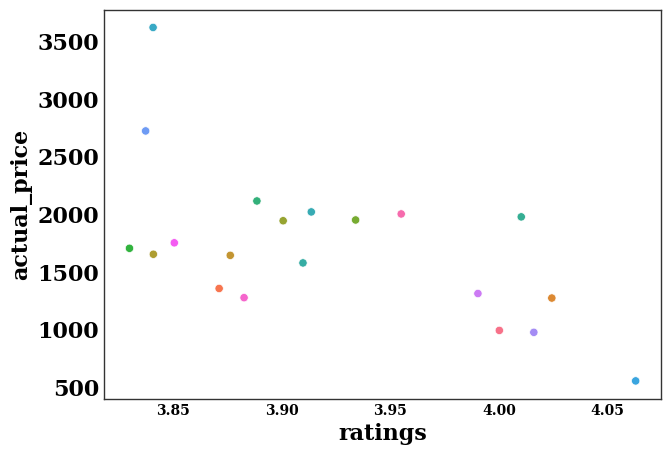

In [183]:
sns.scatterplot(top_ratings,x='ratings',y='actual_price',hue='main_category',legend=False)
# top_ratings.melt(id_vars='main_category')